# Cleaning Essay Text

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import essay_analysis as ea
from collections import Counter
%matplotlib inline

In [3]:
df = pd.read_csv('../data/master.csv', low_memory=False)

### 3 Columns with Essay Data

There are three columns that contain essay text:
- 'Undergraduate Personal Statement'
- 'Undergraduate Essay Details' 
- 'NEW Personal Statement'

Let's rename these columns so they're easier to reference.

In [4]:
old_cols = ['Undergraduate Personal Statement', 'Undergraduate Essay Details', 'NEW Personal Statement']
ce = ea.CleanEssays()
ce.updateEssayCols(df, old_cols)

In [5]:
essay_cols = ['essay_c1','essay_c2','essay_c3']
for col in essay_cols:
    print col, df[col].notnull().sum()

essay_c1 4829
essay_c2 1488
essay_c3 138


### Compute Word Counts

Some entries might be spam or have multiple essays crammed into a single field, the 3 fields / spam data / multiple essays crammed into one field. Let's look at the word counts of each of these columns to get a better sense of what's going on.

In [6]:
ce.updateWordCounts(df,essay_cols)

(       wordcnt_essay_c1  wordcnt_essay_c2  wordcnt_essay_c3
 count       4829.000000       1488.000000        138.000000
 mean         434.138331        258.084005        620.050725
 std          316.843584        480.172369        539.457937
 min            0.000000          0.000000         15.000000
 25%          138.000000         22.000000        218.000000
 50%          500.000000         73.500000        630.500000
 75%          639.000000        368.500000        720.000000
 max         9315.000000       9311.000000       2816.000000,
 <matplotlib.figure.Figure at 0x123431cd0>)

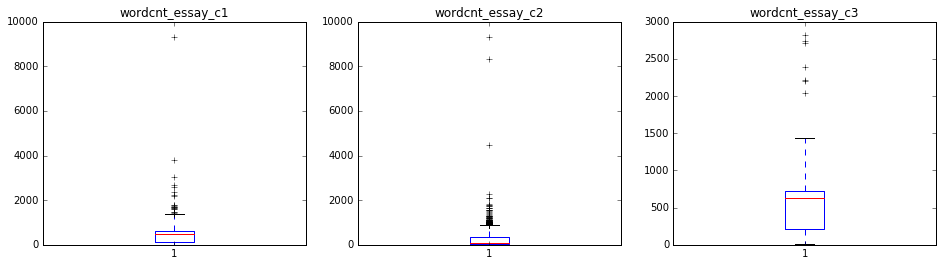

In [7]:
wordcnt_cols = ['wordcnt_'+x for x in essay_cols]
ce.wordCountStats(df, wordcnt_cols)

A couple things strike as problematic:
- Min = 0 or 1 for all three columns: we'll have to set some minimum num of words to filter out the spam and or rows with insufficient text
- Max = almost 10k for essay_c1/essay_c2 and 2-3k for essay_c3: might be spam or multiple essays crammed into one entry.

### essay_c3

Since there are only 138 entries in essay_c3, let's take a look at that first. A quick inspection shows that essay_c3's formatting is a little different from the other two columns. The rows we want take the following form:
```
[integers] [string] string
repeat line for an unspecified [0,n] times
Full Length Personal Statement
*ESSAY TEXT*
[integers] [string] string
repeat line for an unspecified [0,n] times
```
Let's create a new column essay_c3_edit to store the cleaned essays from essay_c3.

In [8]:
df['essay_c3_edit'] = df['essay_c3'].apply(lambda x: ce.cleanEssayC3(x) if not x is np.nan else x)

### essay_c1 & essay_c2

In [9]:
df['Undergraduate Personal Statement Type'].value_counts()

Full Length Personal Statement     4152
Summary Of Personal Statement      1035
Excerpt From Personal Statement     675
Name: Undergraduate Personal Statement Type, dtype: int64

In [10]:
print 'Number of non-null rows where Type = Full Length Personal Statement\n'
for c in essay_cols:
    print c, df[df['Undergraduate Personal Statement Type']=='Full Length Personal Statement'][c].notnull().sum()

Number of non-null rows where Type = Full Length Personal Statement

essay_c1 3437
essay_c2 1111
essay_c3 0


In [11]:
for old,new in zip(essay_cols, ['essay_c1_edit', 'essay_c2_edit']):
    df[new] = df.apply(lambda x: x[old] if x['Undergraduate Personal Statement Type'] ==
                       'Full Length Personal Statement' else np.nan, axis=1)

### ASCII Characters

There are a number of ASCII characters (like \xe2\x80\x99) that we won't want to pass through our model later on, so let's fix this now. We could replace it with the corresponding symbol but it's easier to just remove them (minimal info is lost).

In [12]:
essay_cols_edit = ['essay_c1_edit', 'essay_c2_edit', 'essay_c3_edit']
ce.removeASCII(df, essay_cols_edit)

### Removing Extremes (word count)

Anything less than 200 words should not be considered a full length essay. Let's take a closer look at the distribution of word count.

Based on inspection, after about 1100 words the rate of spam / gibberish goes up drastically. This makes sense- the longest essays are about 1000 words- it's unrealistic that someone would submit something longer than that.

In [13]:
ce.removeExtremes(df, essay_cols_edit)

In [14]:
ce.updateWordCounts(df, essay_cols_edit)

(       wordcnt_essay_c1_edit  wordcnt_essay_c2_edit  wordcnt_essay_c3_edit
 count            3109.000000             345.000000              57.000000
 mean              579.881956             580.408696             601.473684
 std               138.272086             248.703530             135.728209
 min               202.000000             202.000000             210.000000
 25%               499.000000             383.000000             540.000000
 50%               603.000000             543.000000             619.000000
 75%               648.000000             739.000000             650.000000
 max              1094.000000            1098.000000            1029.000000,
 <matplotlib.figure.Figure at 0x118eadad0>)

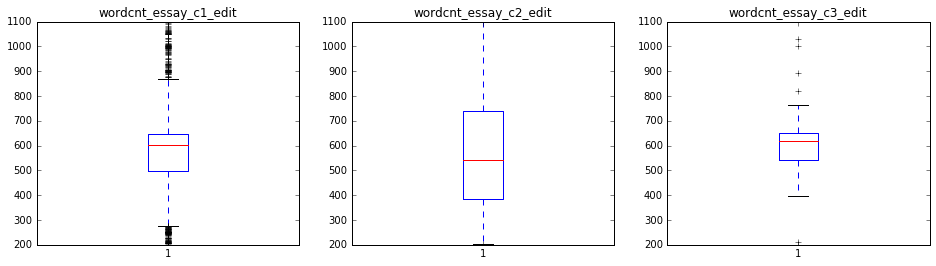

In [15]:
wordcnt_cols_edit = [x+'_edit' for x in wordcnt_cols]
ce.wordCountStats(df, wordcnt_cols_edit)

### Overlapping Data

Now we're ready to take a look at where there is overlapping data (i.e. a row has data in more than one of these essay columns) and create some rule as to which column to keep.

In [16]:
ce.checkOverlaps(df, essay_cols_edit)

The num of rows that contain both c1 and c2: 322
The num of rows that contain both c1 and c3: 0
The num of rows that contain both c2 and c3: 0


Great- we only have to deal with overlaps between c1 and c2. We'll have to create some rule to choose either one, since we cannot keep them both.

In [17]:
print 'There are {} entries where c1 > c2'.format(
    df[df['wordcnt_essay_c1_edit']>df['wordcnt_essay_c2_edit']]['wordcnt_essay_c1_edit'].count())

print 'There are {} entries where c1 < c2'.format(
    df[df['wordcnt_essay_c2_edit']>df['wordcnt_essay_c1_edit']]['wordcnt_essay_c2_edit'].count())

print 'There are {} entries where c1 = c2'.format(
    df[df['wordcnt_essay_c1_edit']==df['wordcnt_essay_c2_edit']]['wordcnt_essay_c1_edit'].count())

There are 169 entries where c1 > c2
There are 142 entries where c1 < c2
There are 11 entries where c1 = c2


##### Case 1: c1 > c2

In [18]:
df[df['wordcnt_essay_c1_edit']>df['wordcnt_essay_c2_edit']][['wordcnt_essay_c1_edit','wordcnt_essay_c2_edit']].describe()

,wordcnt_essay_c1_edit,wordcnt_essay_c2_edit
count,169.000000,169.000000
mean,609.520710,409.189349
std,120.247715,145.738185
min,237.000000,202.000000
25%,535.000000,278.000000
50%,635.000000,398.000000
75%,650.000000,501.000000
max,995.000000,984.000000


In [19]:
# for i in [1,2]:
#     print df[df['wordcnt_essay_c1_edit']>df['wordcnt_essay_c2_edit']]['essay_c{}_edit'.format(i)].values[-1]
#     print '*'*40

From visual inspection of both the first and last 30 or so essays, essay_c1 holds the data for the personal statement, while essay_c1 holds the data for supplemental essays / essay description / etc.

##### Case 2: c2 < c1

In [20]:
df[df['wordcnt_essay_c1_edit']<df['wordcnt_essay_c2_edit']][['wordcnt_essay_c1_edit','wordcnt_essay_c2_edit']].describe()

,wordcnt_essay_c1_edit,wordcnt_essay_c2_edit
count,142.000000,142.000000
mean,542.908451,780.676056
std,117.965610,201.700626
min,216.000000,308.000000
25%,487.250000,607.500000
50%,562.000000,781.500000
75%,639.000000,963.750000
max,994.000000,1098.000000


In [65]:
# for i in [1,2]:
#     print df[df['wordcnt_essay_c1_edit']<df['wordcnt_essay_c2_edit']]['essay_c{}_edit'.format(i)].values[0]
#     print '*'*40

Similar to Case 1 above, from visual inspection of both the first and last 30 or so essays, essay_c1 holds the data for the personal statement, while essay_c1 holds the data for supplemental essays / essay description / etc.

##### Case 3: c1 = c2

In [21]:
df[df['wordcnt_essay_c1_edit']==df['wordcnt_essay_c2_edit']]['essay_c1']

2146     I used to overlook the importance of little th...
2156     I love food. And I come from a family where ev...
3104         Next year, I will be attending the Univers...
3832     The phrase, “the good life”, from my point of ...
3981     After numerous negative outcomes, why would so...
4305     My goal is to attain a career where I can use ...
6491     Depression is never an easy or comfortable top...
7326     Shout it from the Rooftops\n“I’m not voting fo...
8592     I never knew pain so palpable. The shock, the ...
9892     My first option was to go home, an option that...
10059    From the time I was able to realize what a uni...
Name: essay_c1, dtype: object

In [26]:
df[df['wordcnt_essay_c1_edit']==df['wordcnt_essay_c2_edit']]['essay_c2']

2146     I used to overlook the importance of little th...
2156     I love food. And I come from a family where ev...
3104         Next year, I will be attending the Univers...
3832     The phrase, “the good life”, from my point of ...
3981     After numerous negative outcomes, why would so...
4305     My goal is to attain a career where I can use ...
6491     Depression is never an easy or comfortable top...
7326     Shout it from the Rooftops\n“I’m not voting fo...
8592     I never knew pain so palpable. The shock, the ...
9892     My first option was to go home, an option that...
10059    From the time I was able to realize what a uni...
Name: essay_c2, dtype: object

Looks like the essays are identical if wordcount(c1) = wordcount(c2)

##### Decision Rule for Overlaps

In all three cases, c1 is more likely to contain the personal statement, while c2 is more likely to be a supplemental essay / description. A decision rule can then be set in place to keep just the c1 essays in the overlapping cases. In other words, let's set c2 to NaN for these cases. We should keep in mind, however, that this is not strictly true, and may potentially cause minor problems to our analysis later on.

In [22]:
ce.removeOverlaps(df, ['essay_c1_edit','essay_c2_edit'], keep_col = 'essay_c1_edit')

In [23]:
ce.checkOverlaps(df, essay_cols_edit)

The num of rows that contain both c1 and c2: 0
The num of rows that contain both c1 and c3: 0
The num of rows that contain both c2 and c3: 0


Great! Let's do a quick check of our many non-null essay entries we have across the three columns.

In [24]:
df[essay_cols_edit].notnull().sum(axis=0)

essay_c1_edit    3109
essay_c2_edit      23
essay_c3_edit      57
dtype: int64

### Final Checks

Let's now store these good essays into a new column labeled 'essay_final'

In [25]:
reload(ea)
ce = ea.CleanEssays()

In [26]:
df['essay_final'] = df.apply(lambda x: ce.consolidateEssays(x, essay_cols_edit), axis=1)

Doing a final check to ensure we have no duplicates.

In [27]:
df['essay_final'].describe()

count                                                  3189
unique                                                 3177
top       Life is never easy everyone has realized that ...
freq                                                      5
Name: essay_final, dtype: object

Looks like we have a handful of duplicates (count != unique) - let's remove them.

In [28]:
ce.removeDuplicates(df, 'essay_final')

In [29]:
df['essay_final'].describe()

count                                                  3177
unique                                                 3177
top       Every Thursday night at the Recreation center,...
freq                                                      1
Name: essay_final, dtype: object

Great, let's do one more boxplot to make sure our data is good, then export.

(       wordcnt_essay_final
 count          3177.000000
 mean            580.992446
 std             138.608397
 min             202.000000
 25%             499.000000
 50%             604.000000
 75%             648.000000
 max            1094.000000, <matplotlib.figure.Figure at 0x11a156910>)

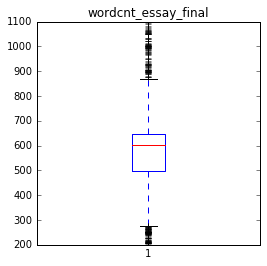

In [30]:
ce.updateWordCounts(df, ['essay_final'])
ce.wordCountStats(df, ['wordcnt_essay_final'], width=4, length=4)

We're ready for our final export now.

### Finally, Export.

In [32]:
df.to_csv('../data/master_essay.csv')